# Wind velocity data

Wind velocity data is available here: https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/climate-forecast-system-version2-cfsv2

Specifically, the Climate Forecast System Reanalysis (CFSR) gives estimates of global wind velocity on a 0.5° scale, with an hourly resolution, since 1 January 1979 through 31 March 2011.

The CFSR is hosted by FTP here: ftp://nomads.ncdc.noaa.gov/CFSR/HP_time_series/

All the data is in GRIB2 format, which can be read using `pygrib`. There's an example of how to interact with the data here: http://polar.ncep.noaa.gov/waves/examples/usingpython.shtml. Some documentation of pygrib is here: https://jswhit.github.io/pygrib/docs/pygrib.gribmessage-class.html.

### Wind velocity at 10m

The most useful data for wind energy seems to be `wnd10m`, which gives the wind velocity vector at 10m above the surface of the Earth. The naming format is "wnd10m.gdas.yyyymm.grb2", or "wnd10m.l.gdas.yyyymm.grb2" for the low-resolution data.

In [ ]:
from __future__ import print_function, division
import numpy as np
import pygrib

Go to the CFSR FTP site (see intro above) and download the filename given in the cell below, putting it in a "data" folder.

In [67]:
fname = 'data/wnd10m.l.gdas.201006.grb2'
f = pygrib.open(fname)

Select the (u,v) vector components of wind velocity:

In [68]:
sel_u = f.select(name='10 metre U wind component')
sel_v = f.select(name='10 metre V wind component')

In [69]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import colormaps

Define a function to convert (u,v) vector components to a power per unit area (on the surface of the Earth). Assumes a given wind turbine efficiency (20% by default) and spacing of different wind turbines (5 blade lengths, by default).

In [70]:
import astropy.units as units
rho_air = 1.225 * units.kg / units.m**3

def uv2powerdensity(u, v, efficiency=0.2, spacing=5.):
    s = np.sqrt(u**2 + v**2) * units.m / units.s
    return 0.5 * efficiency / spacing**2. * rho_air * s**3

Define function to plot wind power density over the surface of the Earth:

In [71]:
def get_row(idx):
    row_u = sel_u[idx]
    row_v = sel_v[idx]
    lat,lon = row_u.latlons()
    t = row_u.analDate
    u = row_u.values
    v = row_v.values
    return lat, lon, t, u, v

def plot_power_density(idx, **kwargs):
    lat, lon, t, u, v = get_row(idx)
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    m = Basemap(ax=ax,
                projection='moll',
                lon_0=180.,
                lat_0=0.)
    
    x, y = m(lon, lat)
    
    rho_power = (uv2powerdensity(u, v) / units.Unit('W / m2')).decompose().value
    
    cs = m.pcolormesh(
        x, y, np.log10(rho_power),
        shading='flat',
        cmap=colormaps.inferno,
        **kwargs)
    
    m.drawcoastlines(color=(1.,1.,1.,0.25))
    
    cbar = fig.colorbar(cs, orientation='horizontal')
    cbar.set_label(
        r'$\log_{10} \left[ \mathrm{Power \ Density} \ \left( \mathrm{W} / \mathrm{m}^{2} \right) \right]$',
        fontsize=14)
    
    ax.set_title(str(t) + ' UTC')
    
    fig.savefig('plots/log_power_density_{:04d}.png'.format(idx))
    plt.close(fig)

### WARNING:
The cell below may leak a lot of memory. I'm not sure why this happens, since I'm trying to close each plot, but it may have something to do with how Jupyter inlines matplotlib plots.

The below code will drop `png` images of the wind power density across the surface of the Earth into a directory called "plots".

In [ ]:
for i in range(len(sel_u)):
    print(i)
    plot_power_density(i, vmin=-1., vmax=2.)

To turn these plots into a video on a \*nix system, you can install `ffmpeg` with `x264` support, and then run the following command from the "plots" folder:

    ffmpeg -r 10 -i log_power_density_%04d.png \
           -c:v libx264 -q:v 10 -r 10 log_power_density.mp4

If you have `x265` support installed, then you can generate an HEVC video as follows:

    ffmpeg -r 10 -i log_power_density_%04d.png \
           -c:v libx265 -q:v 10 -strict experimental \
           log_power_density_x265.mp4

Now, we'll generate a plot of time vs. integrated wind power over the entire Earth, just the land, and the land + seaboard. We define the seaboard as anything one pixel away from land (not very scientific, but better than nothing - it would be better to use topographic data to select shallow water close to land).

In [73]:
from astropy.convolution import Box2DKernel, convolve

radius_earth = 6371 * units.km
population_earth = 7.125e9
kWh_per_day = units.Unit('kW h / d')

def gen_is_land():
    m_cyl = Basemap(projection='cyl', lon_0=180., lat_0=0.)
    def f_tmp(lon, lat):
        x,y = m_cyl(lon, lat)
        return m_cyl.is_land(x, y)
    return np.frompyfunc(f_tmp, 2, 1)

is_land = gen_is_land()

def gen_mask_water():
    lat, lon, t, u, v = get_row(0)
    return ~(is_land(lon, lat).astype('bool'))

mask_water = gen_mask_water()
mask_water_far = ~(convolve(~mask_water, Box2DKernel(3)).astype('bool'))

def integrate_power_density(idx, select='all'):
    lat, lon, t, u, v = get_row(idx)
    rho_power = uv2powerdensity(u, v)
    w = np.cos(np.radians(lat))
    norm = 4. * np.pi * radius_earth**2. / np.sum(w)
    if select == 'land':
        w[mask_water] = 0.
    elif select == 'land+seaboard':
        w[mask_water_far] = 0.
    power = norm * np.sum(w * rho_power)
    return power.to(kWh_per_day)

In [75]:
integrate_power_density(205, select='land+seaboard') / population_earth

<Quantity 411.1624704143095 h kW / d>

Generate the time series for the three different regions:

In [76]:
t_series = [row_u.analDate for row_u in sel_u]
power_timeseries = {}
for key in ['total', 'land', 'land+seaboard']:
    print('{} ...'.format(key))
    power_timeseries[key] = units.Quantity(
        [integrate_power_density(idx, select=key)
         for idx in range(len(sel_u))])

total ...
land ...
land+seaboard ...


Plot the time series. The values should be on the order of 5000 kWh/day/person total, 150 kWh/day/person over land, and 450 kWh/day/person for land + seaboard.

For comparison, the total energy usage (including not just direct electricity usage, but also energy needed for agriculture, production of stuff, and transportation) of an American is about 250 kWh/day. This means that were 100% of land and seaboard covered with windmills, there would be enough to power about 180% of the human race's needs (assuming everyone in the future consumes as much energy as Americans do today). This would obviously be impractical, but wind energy could provide a good fraction of total power needs, especially if we become more efficient with power usage.

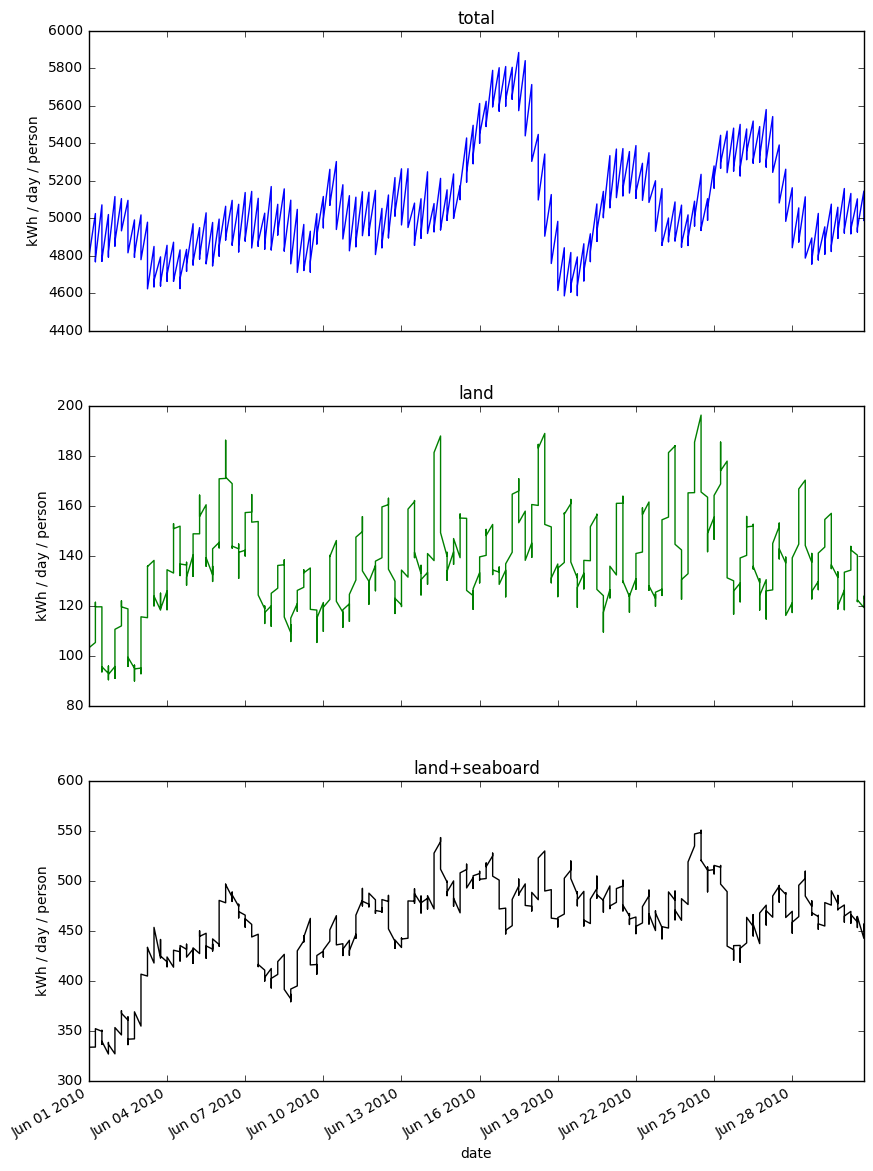

In [77]:
fig = plt.figure(figsize=(10,15))

keys = ['total', 'land', 'land+seaboard']
styles = ['b-', 'g-', 'k-']

for i,(key,s) in enumerate(zip(keys,styles)):
    ax = fig.add_subplot(3,1,i+1)
    y = power_timeseries[key].value / population_earth
    ax.plot_date(t_series, y, s)
    ax.set_xlabel('date')
    ax.set_ylabel('kWh / day / person')
    ax.set_title(key)

fig.autofmt_xdate()

fig.subplots_adjust(hspace=0.25)

plt.show()